[View in Colaboratory](https://colab.research.google.com/github/ajoshiusc/deepReg/blob/master/deep_rigid.ipynb)

Saving sample_brain.png to sample_brain.png
------------------------------
Loading and preprocessing train data...
------------------------------
Creating and compiling model...
Fitting Model
Train on 1638 samples, validate on 410 samples
Epoch 1/20
1638/1638 [==============================] - 40s 24ms/step - loss: 725.9811 - mean_squared_error: 725.9811 - val_loss: 60.2157 - val_mean_squared_error: 60.2157
Epoch 2/20
1638/1638 [==============================] - 28s 17ms/step - loss: 40.6159 - mean_squared_error: 40.6159 - val_loss: 32.9557 - val_mean_squared_error: 32.9557
Epoch 3/20
1638/1638 [==============================] - 28s 17ms/step - loss: 29.0748 - mean_squared_error: 29.0748 - val_loss: 24.5971 - val_mean_squared_error: 24.5971
Epoch 4/20
1638/1638 [==============================] - 28s 17ms/step - loss: 20.2797 - mean_squared_error: 20.2797 - val_loss: 20.0164 - val_mean_squared_error: 20.0164
Epoch 5/20
1638/1638 [==============================] - 28s 17ms/step - loss: 1

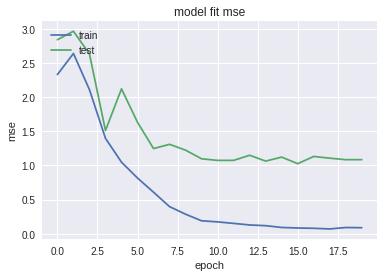

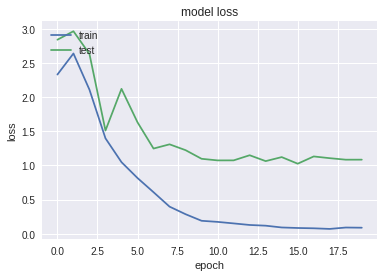

Test data...
4/4 [==============================] - 1s 154ms/step


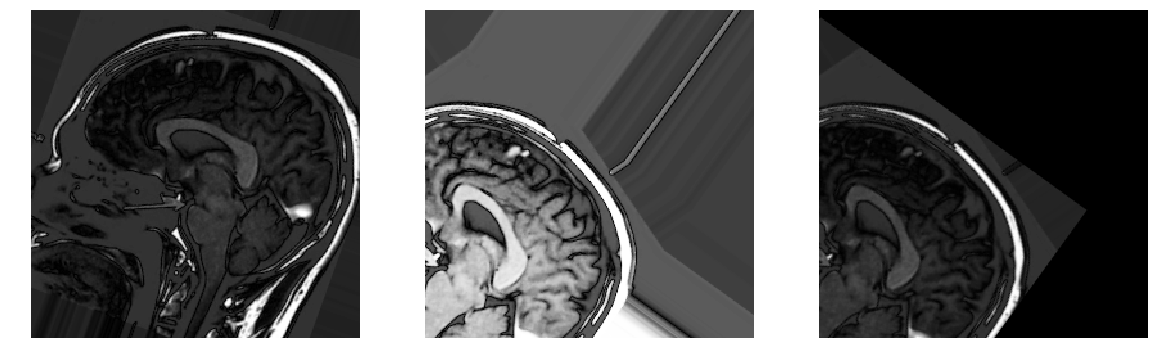

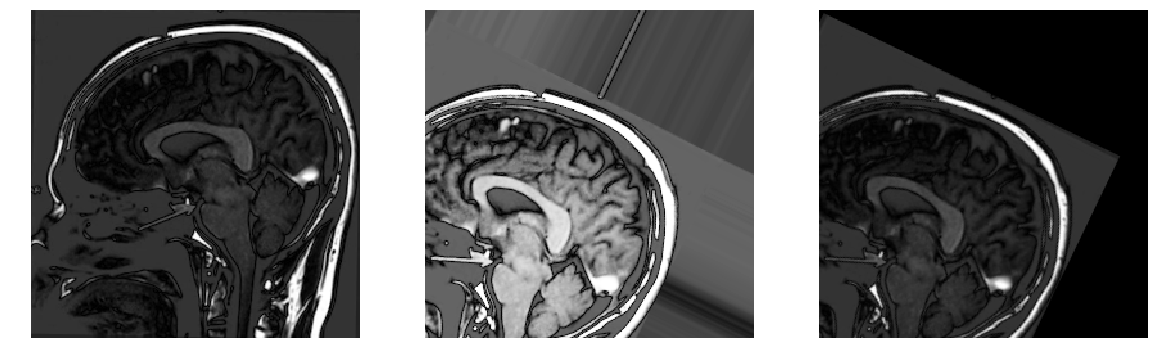

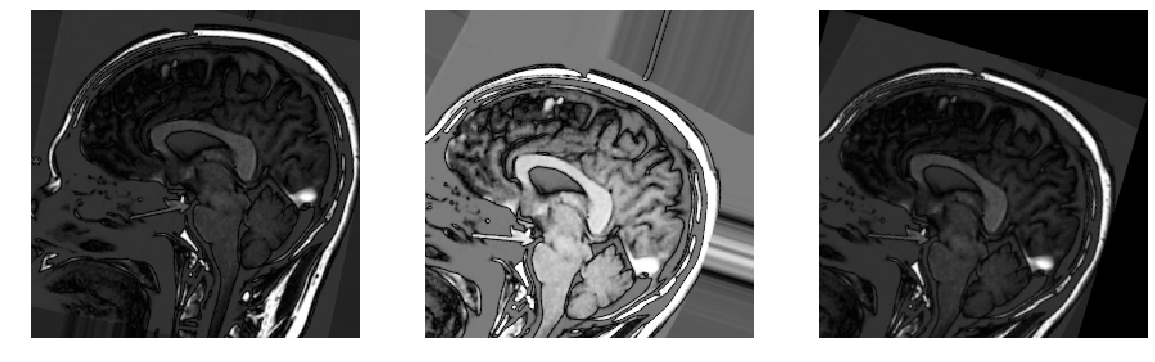

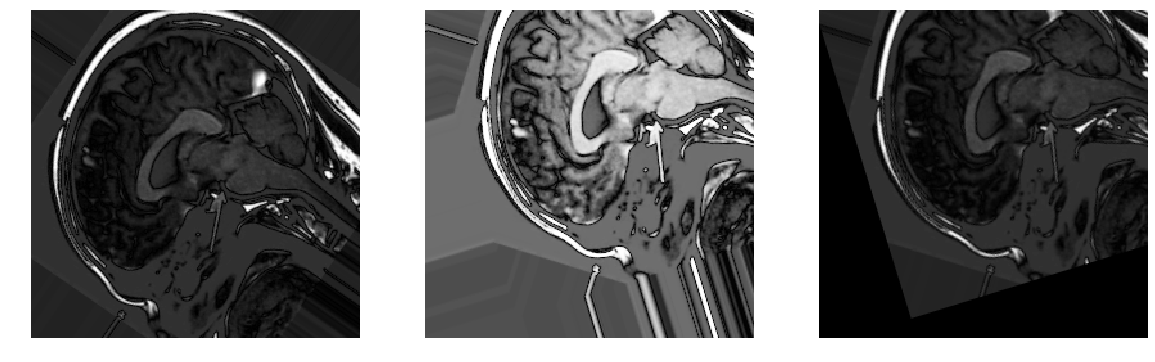

[[-35.92999    -4.4799504  -4.8935304]
 [-25.753506   -4.520047   -1.5609957]
 [-16.181208   -8.404013    4.0531855]
 [ 17.30166     3.0522382   4.84479  ]]
[[-35.85533668  -4.83175727  -4.53657904]
 [-25.98959904  -5.18082844  -0.74132089]
 [-16.82126771  -9.25486187   4.51930412]
 [ 17.21744577   2.91680221   5.19898629]]


In [2]:
#AUM
#Shree Ganeshaya Namaha
from skimage import transform as tf
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage.io import imread
from keras.layers import Input,Conv2D,concatenate,MaxPooling2D,Flatten,Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from skimage.viewer import ImageViewer
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import files
uploaded = files.upload()


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

from keras import losses
img_rows = 256
img_cols = 256


#taken from: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



def get_rr_net():
    inputs = Input((img_rows, img_cols, 2))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    flat1 = Flatten()(conv5)
    d1= Dense(512,activation='relu')(flat1)
    d2= Dense(64,activation='relu')(d1)

    out_theta = Dense(3)(d2)
#    conv_tx = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_ty = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_theta = Conv2D(1, (1, 1), activation='tanh')(conv5)

#    out_img = rotate(inputs,conv_theta)

    model = Model(inputs=[inputs], outputs=out_theta)

    model.compile(optimizer='adam', loss=losses.mean_squared_error, metrics=['mse'])

    return model


def gen_train_data(img, N=1024,  nodist=1):
    imgs_train = np.zeros((N, img.shape[0], img.shape[1], 2))
    noise = 0.01*uniform(low=-1,high=1,size=imgs_train.shape)
    out_train = np.zeros((N, 3))
    rot = uniform(low=-60, high=60, size=(N,1))
    tx = uniform(low=-10, high=10, size=(N,1))
    ty = uniform(low=-10, high=10, size=(N,1))
    out_train[:,0]=rot.squeeze()
    out_train[:,1]=tx.squeeze()
    out_train[:,2]=ty.squeeze()

    in_rot = uniform(low=-60, high=60, size=(N,1))
 
    for j in range(N):
      
#        img2 = tf.warp(img,aff)
        img2 = rotate(img, in_rot[j],mode='edge')
        img2 -= np.mean(img2)
        img2 /= np.std(img2)
        if nodist==0:
            img2 = elastic_transform(img2, img2.shape[1] * 1.2, img2.shape[1] * 0.08,img2.shape[1] * 0.08)
        
        imgs_train[j, :, :, 0] = img2 + (1.0-nodist)*noise[j,:,:,0]
       
        aff = tf.AffineTransform(rotation = (np.pi/180.0)*np.float(rot[j]), translation=(tx[j],ty[j]))

        #img3 = 10-1*np.tanh(img2) + 0*  noise[j,:,:,1]#
        img3 = 10-1*np.tanh(tf.warp(img2, aff, mode='edge')) +  (1.0-nodist)*noise[j,:,:,1]#
        
        if nodist == 0:
            img3 = elastic_transform(img3, img3.shape[1] * 1.2, img3.shape[1] * 0.08,img3.shape[1] * 0.08)

        img3 -= np.mean(img3)
        img3 /= np.std(img3)
        imgs_train[j, :, :, 1] = img3
        
        if 0:
            plt.imshow(img3)
            plt.show()
            
            plt.imshow(img2)
            plt.show()
             
    return imgs_train, out_train


def train_model():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    img = resize(rgb2gray(imread('sample_brain.png')).astype('float32'),(img_rows,img_cols),mode='constant')
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization

    img -= mean
    img /= std
    

    print('Creating and compiling model...')
    rrmodel = get_rr_net()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('Fitting Model')

    for jjj in range(10):
      imgs_train, out_train = gen_train_data(img, 2*1024)
      history = rrmodel.fit(imgs_train, out_train, batch_size=32, epochs=20, verbose=1,
                  shuffle=True, validation_split=0.2,
                  callbacks=[model_checkpoint])
    
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model fit mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def test_model():
    
    print('Test data...')
    img = resize(rgb2gray(imread('sample_brain.png')).astype('float32'),(img_rows,img_cols),mode='reflect')
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization

    img -= mean
    img /= std

    rrmodel = get_rr_net()
    rrmodel.load_weights('weights.h5')

    imgs_test, out_test = gen_train_data(img, 4, nodist=1)
#    plt.imshow(np.absolute(imgs_test[0,:,:,0].squeeze()),cmap='gray')
#    plt.imshow(np.absolute(imgs_test[0,:,:,1].squeeze()),cmap='gray')

    pred_theta = rrmodel.predict(imgs_test, verbose=1)

    for jj in range(4):
        fig=plt.figure(figsize=(20,10)); 
        fig.add_subplot(1,3,1);ax = plt.gca(); ax.grid(False)
        plt.axis('off')
        plt.imshow(np.absolute(imgs_test[jj,:,:,0].squeeze()),cmap='gray')
        fig.add_subplot(1,3,2);ax = plt.gca(); ax.grid(False)
        plt.axis('off')
        plt.imshow(np.absolute(imgs_test[jj,:,:,1].squeeze()),cmap='gray')
        aff = tf.AffineTransform(rotation = (np.pi/180.0)*pred_theta[jj,0], translation=(pred_theta[jj,1],pred_theta[jj,2]))
        img2 = tf.warp(np.absolute(imgs_test[jj,:,:,0].squeeze()),aff)
        fig.add_subplot(1,3,3);ax = plt.gca(); ax.grid(False)
        plt.axis('off')
        plt.imshow(img2,cmap='gray')
        plt.show()
    
    
    print(pred_theta)
    print(out_test)



if __name__ == '__main__':
    train_model()
    test_model()


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.3 GB  | Proc size: 4.0 GB
GPU RAM Free: 501MB | Used: 10938MB | Util  96% | Total 11439MB
